In [1]:
from __future__ import division

import PerformParser as pp
import pandas as pd
import numpy as np
from scipy import signal as sig
import performFun as pF

import bokeh.plotting as bkP
import bokeh.models as bkM
from bokeh.palettes import Spectral6
bkP.output_notebook() 

import cv2
import os
import scipy.io as sio
import matplotlib

%matplotlib notebook
from ipywidgets import interact
import filterpy as fP
from bokeh.io import push_notebook

import Quaternion as qu

import plotly
from plotly.graph_objs import Scatter, Layout
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print plotly.__version__

plotly.offline.init_notebook_mode()

import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft
from mpl_toolkits.mplot3d import Axes3D

bkP.output_notebook()

#bkP.output_file('timeSeries.html') 

#%pylab inline
#%matplotlib notebook


/Users/kamranbinaee/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading BokehJS ...

1.12.9


Loading BokehJS ...

In [ ]:


# List of subjects with good calibration quality
fileTimeList = ['2016-4-19-14-4', '2016-4-22-11-57', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
                '2016-5-3-12-52', '2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
fileTimeList = ['2016-4-19-14-4'] # 
fileTimeList = ['2016-12-2-19-22'] # Evan's Data

rawDataFrame = pd.DataFrame()
processedDataFrame = pd.DataFrame()
calibDataFrame = pd.DataFrame()
trialInfoDataFrame =  pd.DataFrame()
#fileTime = '2016-4-22-11-57'
#fileTime = '2016-4-27-13-28'
#fileTime = '2016-4-28-10-57'
#fileTime = '2016-4-29-11-56'
#fileTime = '2016-5-3-12-52'
#fileTime = '2016-5-4-13-3'
#fileTime = '2016-5-5-13-7'
#fileTime = '2016-5-6-11-2'
#fileTime = '2016-5-6-13-4'
expCfgName = "gd_pilot.cfg"
sysCfgName = "PERFORMVR.cfg"

saveSubjectPickle = False
startFromScratch = False

if startFromScratch == True:
    for fileTime in fileTimeList:

        print 'extracting data for:', fileTime
        filePath = "../Data/exp/" + fileTime + "/"
        fileName = "exp_data-" + fileTime

        sessionDict = pF.loadSessionDict(filePath,fileName,expCfgName,sysCfgName,startFresh=False)
        sessionDict['processed'], sessionDict['trialInfo'] = pF.calculateCrossingFrame(sessionDict['raw'], sessionDict['processed'], sessionDict['trialInfo'])
        rawDataFrame = rawDataFrame.append(sessionDict['raw'], ignore_index=True)
        processedDataFrame = processedDataFrame.append(sessionDict['processed'], ignore_index=True)
        calibDataFrame = calibDataFrame.append(sessionDict['calibration'], ignore_index=True)
        trialInfoDataFrame = trialInfoDataFrame.append(sessionDict['trialInfo'], ignore_index=True)
else:
    print 'Reading the All Subject Pickle File'
    df = pd.read_pickle('AllSubjects_2.pickle')
    rawDataFrame = df['raw']
    processedDataFrame = df['processed']
    calibDataFrame = df['calibration']
    trialInfoDataFrame = df['trialInfo']
    

if saveSubjectPickle == True:
    sessionDict['raw'] = rawDataFrame
    sessionDict['processed'] = processedDataFrame
    sessionDict['calibration'] = calibDataFrame
    sessionDict['trialInfo'] = trialInfoDataFrame
    pd.to_pickle(sessionDict, 'AllSubjects_2.pickle')
    print 'All Subject Pickle Saved'

processedDataFrame.loc[:, ('headVelocity','')] = pF.calculateHeadVelocity(rawDataFrame, trialID = None, plottingFlag = False)
processedDataFrame.loc[:, ('ballVelocity','')] = pF.calculateBallVelocity(rawDataFrame, processedDataFrame, trialID = None, plottingFlag = False)

trialStartIdx = processedDataFrame[processedDataFrame['eventFlag'] == 'trialStart'].index.tolist()
ballOffIdx = processedDataFrame[processedDataFrame['eventFlag'] == 'ballRenderOff'].index.tolist()
ballOnIdx = processedDataFrame[processedDataFrame['eventFlag'] == 'ballRenderOn'].index.tolist()
ballOnPaddleIdx = processedDataFrame[processedDataFrame['eventFlag'] == 'ballOnPaddle'].index.tolist()

ballCrossingIdx = np.zeros(len(trialInfoDataFrame), dtype = int)
ballCrossingIdx[trialInfoDataFrame.ballCaughtQ.values == True] = processedDataFrame[processedDataFrame['eventFlag'] == 'ballOnPaddle'].index.tolist()
ballCrossingIdx[trialInfoDataFrame.ballCaughtQ.values == False] = processedDataFrame[processedDataFrame['eventFlag'] == 'ballCrossingPaddle'].index.tolist()

trialInfoDataFrame.loc[:, ('trialStartIdx','')] = trialStartIdx
trialInfoDataFrame.loc[:, ('ballOffIdx','')] = ballOffIdx
trialInfoDataFrame.loc[:, ('ballOnIdx','')] = ballOnIdx
trialInfoDataFrame.loc[:, ('ballCrossingIndex','')] = ballCrossingIdx
print 'Number of Successful Trials: ', len(ballOnPaddleIdx), 'out of', len(trialStartIdx)
print 'Done!'


Reading the All Subject Pickle File


ballPosition = np.array(rawDataFrame.ballPos.values)
handPosition = np.array(rawDataFrame.paddlePos.values)
gazePosition = np.array(processedDataFrame.gazePoint.values)
ballVelocity = np.array(processedDataFrame.ballVelocity.values)
gazeVelocity = np.array(processedDataFrame.cycGazeVelocity.values)
renderingFlag = np.array(rawDataFrame.isBallVisibleQ.values*1)
#list(rawDataFrame.columns)
print ballPosition.shape, handPosition.shape, gazePosition.shape, renderingFlag.shape, ballVelocity.shape

dataBase = np.zeros((ballPosition.shape[0], 11))
dataBase[:,0:3] = ballPosition
dataBase[:,3:6] = handPosition
dataBase[:,6:8] = gazePosition[:,0:2]
dataBase[:,8] = ballVelocity
dataBase[:,9] = gazeVelocity
dataBase[:,10] = renderingFlag
print dataBase.shape
        

In [ ]:
processedDataFrame

In [9]:
eyeToScreenDistance = 0.0725
handPosition = np.zeros((1,3), dtype = float)
ballPosition = np.zeros((1,2), dtype = float)
gazePosition = np.zeros((1,2), dtype = float)
ballVelocity = np.array([], dtype = float)
gazeVelocity = np.array([], dtype = float)
renderingFlag = np.array([], dtype = float)
trialEndIndex = np.array([], dtype = float)

rawDataFrame.ix[rawDataFrame.isBallVisibleQ.values == False, ('ballPos','X')] = 0.0
rawDataFrame.ix[rawDataFrame.isBallVisibleQ.values == False, ('ballPos','Y')] = 0.0
rawDataFrame.ix[rawDataFrame.isBallVisibleQ.values == False, ('ballPos','Z')] = 0.0
processedDataFrame.ix[rawDataFrame.isBallVisibleQ.values == False, ('ballVelocity')] = 0.0
for i in range(len(trialInfoDataFrame)):
    if (trialInfoDataFrame.ballCaughtQ.values[i] == False):
        endFrame = trialInfoDataFrame.ballCrossingIndex.values[i]

        #x = np.array(processedDataFrame.ballOnScreen.X.values[trialStartIdx[i]:endFrame])
        #y = np.array(processedDataFrame.ballOnScreen.Y.values[trialStartIdx[i]:endFrame])
        x = np.array(rawDataFrame.ballPos.X.values[trialStartIdx[i]:endFrame])
        y = np.array(rawDataFrame.ballPos.Y.values[trialStartIdx[i]:endFrame])
        processedDataFrame.loc[trialStartIdx[i]:endFrame-1, ('ballOnScreen','X')] = (180/np.pi)*np.arctan(x.astype(float)/eyeToScreenDistance)
        processedDataFrame.loc[trialStartIdx[i]:endFrame-1, ('ballOnScreen','Y')] = (180/np.pi)*np.arctan(y.astype(float)/eyeToScreenDistance)
        tempVar = processedDataFrame.ballOnScreen.values[trialStartIdx[i]:endFrame, 0:2]
        ballPosition = np.vstack((ballPosition, tempVar))

        tempVar = rawDataFrame.paddlePos.values[trialStartIdx[i]:endFrame]
        handPosition = np.vstack((handPosition, tempVar))

        x = processedDataFrame.gazePoint.X.values[trialStartIdx[i]:endFrame]
        y = processedDataFrame.gazePoint.Y.values[trialStartIdx[i]:endFrame]
        processedDataFrame.loc[trialStartIdx[i]:endFrame-1, ('gazePoint','X')] = (180/np.pi)*np.arctan(x/eyeToScreenDistance)
        processedDataFrame.loc[trialStartIdx[i]:endFrame-1, ('gazePoint','Y')] = (180/np.pi)*np.arctan(y/eyeToScreenDistance)
        tempVar = processedDataFrame.gazePoint.values[trialStartIdx[i]:endFrame, 0:2]
        gazePosition = np.vstack((gazePosition, tempVar))

        tempVar = processedDataFrame.ballVelocity.values[trialStartIdx[i]:endFrame]
        ballVelocity = np.hstack((ballVelocity, tempVar))

        tempVar = processedDataFrame.cycGazeVelocity.values[trialStartIdx[i]:endFrame]
        gazeVelocity = np.hstack((gazeVelocity, tempVar))

        tempVar = rawDataFrame.isBallVisibleQ.values[trialStartIdx[i]:endFrame]
        renderingFlag = np.hstack((renderingFlag, tempVar))
        tempVar = np.zeros(endFrame - trialStartIdx[i])
        tempVar[-1] = 1
        trialEndIndex = np.hstack((trialEndIndex, tempVar))
ballPosition = np.delete(ballPosition, 0,0)
handPosition = np.delete(handPosition, 0, 0)
gazePosition = np.delete(gazePosition, 0, 0)
print ballPosition.shape, handPosition.shape, gazePosition.shape, ballVelocity.shape, gazeVelocity.shape, renderingFlag.shape
dataBase = np.zeros((ballPosition.shape[0], 10))
dataBase[:,0:3] = handPosition
dataBase[:,3:5] = gazePosition[:,0:2]
dataBase[:,5] = gazeVelocity
dataBase[:,6:8] = ballPosition
dataBase[:,8] = ballVelocity
dataBase[:,9] = renderingFlag
print dataBase.shape
print dataBase.mean(axis = 0)
print dataBase.std(axis = 0)
print dataBase.max(axis = 0)
print dataBase.min(axis = 0)
print len(trialEndIndex)

(63527, 2) (63527, 3) (63527, 2) (63527,) (63527,) (63527,)
(63527, 10)
[ -0.62493976   1.50276377   0.55305995 -74.16790893  76.77583431
  32.21687411 -59.74270334  60.56495033  49.19034072   0.68292222]
[   0.26436697    0.37570783    0.3311131    49.67101496   44.79276456
   43.3692191    40.93983893   41.270874    136.86179596    0.46533801]
[  3.18389744e-01   2.37108493e+00   2.14362192e+00   8.99062019e+01
   8.99305901e+01   1.90334615e+03   7.62016732e+01   8.94041373e+01
   1.25429268e+04   1.00000000e+00]
[ -1.94430625e+00   3.04265857e-01  -7.65858710e-01  -8.99049890e+01
  -8.98359828e+01   8.08137191e-02  -8.96008361e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
63527


In [10]:
print 'Data Size = ', dataBase.shape
print '\nMean Values = ', dataBase.mean(axis = 0)
print '\nSTD Values = ', dataBase.std(axis = 0)
print '\nMax Values = ', dataBase.max(axis = 0)
print '\nMin Values = ', dataBase.min(axis = 0)
#pd.to_pickle(dataBase, 'DataSet_Unformatted_Fail.pickle')
np.save('DataSet_Unformatted_Fail', dataBase)

Data Size =  (63527, 10)

Mean Values =  [ -0.62493976   1.50276377   0.55305995 -74.16790893  76.77583431
  32.21687411 -59.74270334  60.56495033  49.19034072   0.68292222]

STD Values =  [   0.26436697    0.37570783    0.3311131    49.67101496   44.79276456
   43.3692191    40.93983893   41.270874    136.86179596    0.46533801]

Max Values =  [  3.18389744e-01   2.37108493e+00   2.14362192e+00   8.99062019e+01
   8.99305901e+01   1.90334615e+03   7.62016732e+01   8.94041373e+01
   1.25429268e+04   1.00000000e+00]

Min Values =  [ -1.94430625e+00   3.04265857e-01  -7.65858710e-01  -8.99049890e+01
  -8.98359828e+01   8.08137191e-02  -8.96008361e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [11]:
inputLength = range(5,21)
inputLength = [5,10,15,20]

for count in inputLength:
    myCounter = 0
    formattedDataBase = np.zeros((10,count, dataBase.shape[0] - count))
    for i in range(dataBase.shape[0] - count ):
        if (all(v == 0 for v in trialEndIndex[i:i+count])):
            formattedDataBase[:,:,i] = dataBase[i:i+count, :].T
        elif trialEndIndex[i+count-1] == 1:
            #print trialEndIndex[i:i+count]
            formattedDataBase[:,:,i] = dataBase[i:i+count, :].T
            myCounter = myCounter + 1
    print myCounter

    print 'Final DataBase Size = ', formattedDataBase.shape
    pd.to_pickle(formattedDataBase, 'DataSet_'+ str(count)+'_Fail.pickle')

sampleIndex = 0
#print 'Just To make sure that the data is correctly formatted'
#print 'First Sample =  \n',formattedDataBase[:,:,sampleIndex]
#print '\n\nSecond Sample = \n', formattedDataBase[:,:,sampleIndex+1]
#print '\n\nThird Sample = \n', formattedDataBase[:,:,sampleIndex+2]

534
Final DataBase Size =  (10, 5, 63522)
534
Final DataBase Size =  (10, 10, 63517)
534
Final DataBase Size =  (10, 15, 63512)
534
Final DataBase Size =  (10, 20, 63507)


In [ ]:
dataSet = pd.read_pickle('DataSet_5.pickle')
print dataSet.shape

In [ ]:
#(180/np.pi)*np.arctan(x.astype(float)/eyeToScreenDistance)

In [ ]:
print 'Mean Values for each Feature = \n', np.round(dataSet.mean(axis=1).mean(axis=1), 3).T

In [ ]:
print 'Max Values for each Feature = \n', np.round(dataSet.max(axis=1).max(axis=1), 3).T

In [ ]:
print 'Min Values for each Feature = \n', np.round(dataSet.min(axis=1).min(axis=1), 3).T

In [ ]:
#processedDataFrame.ix[rawDataFrame.isBallVisibleQ.values == False, ('ballVelocity')] = 0.0

In [ ]:
#rawDataFrame.ballPos.values[600:900]
#processedDataFrame.gazePoint.Y.values[600:900]*(180/np.pi)
print gazePosition.mean(axis = 0)
print gazePosition.max(axis = 0)
print gazePosition.min(axis = 0)

In [2]:
predictedData = np.load('predict_inseq10.npy')
testData = np.load('data_test_inseq10.npy')

(10239, 5)
(10239, 5)


<IPython.core.display.Javascript object>


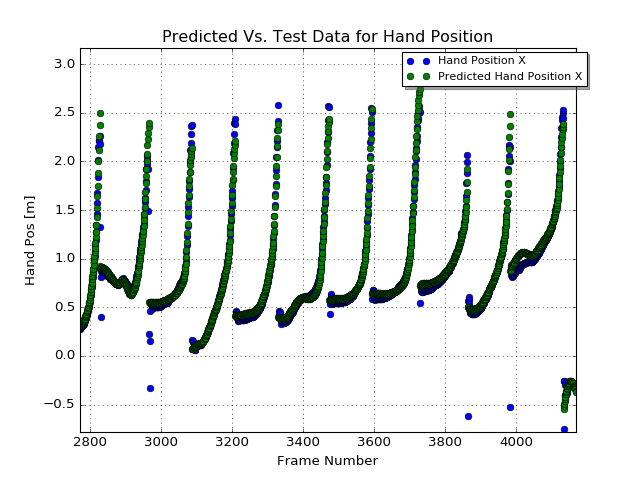

In [5]:
startFrame = 0
endFrame = predictedData.shape[0]
x = range(startFrame,endFrame)
y1 = predictedData[startFrame:endFrame, 0]
y2 = predictedData[startFrame:endFrame, 1]
y3 = predictedData[startFrame:endFrame, 2]

y4 = testData[startFrame:endFrame, 0]
y5 = testData[startFrame:endFrame, 1]
y6 = testData[startFrame:endFrame, 2]
print predictedData.shape
print testData.shape
fig1 = plt.figure()
plt.plot(x, y1, 'bo', label='Hand Position X')
#plt.plot(x, y2, 'bo', label='Hand Position Y')
#plt.plot(x, y3, 'bo', label='Hand Position Z')

plt.plot(x, y4, 'go', label='Predicted Hand Position X')
#plt.plot(x, y5, 'go', label='Predicted Hand Position Y')
#plt.plot(x, y6, 'go', label='Predicted Hand Position Z')
#l1, = plt.plot([],[])

#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.xlabel('Frame Number')
plt.ylabel('Hand Pos [m]')
plt.title('Predicted Vs. Test Data for Hand Position')
plt.grid(True)
#plt.axis('equal')
#line_ani = animation.FuncAnimation(fig1, update_line1, frames = 11448, fargs=(sessionData, l1), interval=14, blit=True)
legend = plt.legend(loc=[0.65,0.9], shadow=True, fontsize='small')# 'upper center'
plt.show()

In [ ]:
startFrame = 0
endFrame = predictedData.shape[0]
x = range(startFrame,endFrame)
y1 = predictedData[startFrame:endFrame, 3]
y2 = predictedData[startFrame:endFrame, 4]

y4 = testData[startFrame:endFrame, 3]
y5 = testData[startFrame:endFrame, 4]
print predictedData.shape
print testData.shape
fig1 = plt.figure()
#plt.plot(x, y1, 'ro', label='Gaze Position Elevation')
plt.plot(x, y2, 'ro', label='Gaze Position Azimuth')

#plt.plot(x, y4, 'yo', label='Predicted Gaze Position Elevation')
plt.plot(x, y5, 'yo', label='Gaze Position Azimuth')
#l1, = plt.plot([],[])

#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
plt.xlabel('Frame Number')
plt.ylabel('Gaze Pos [degree]')
plt.title('Predicted Vs. Test Data for Gaze Position')
plt.grid(True)
#plt.axis('equal')
#line_ani = animation.FuncAnimation(fig1, update_line1, frames = 11448, fargs=(sessionData, l1), interval=14, blit=True)
legend = plt.legend(loc=[0.65,0.9], shadow=True, fontsize='small')# 'upper center'
plt.show()

In [6]:
np.save('Sample_1', dataBase[0:305,:])
np.save('Sample_2', dataBase[0:306,:])
np.save('Sample_3', dataBase[0:307,:])
np.save('Sample_4', dataBase[0:308,:])
np.save('Sample_5', dataBase[0:309,:])
np.save('Sample_6', dataBase[0:310,:])
np.save('Sample_7', dataBase[0:311,:])
np.save('Sample_8', dataBase[0:312,:])
np.save('Sample_9', dataBase[0:313,:])
np.save('Sample_10', dataBase[0:314,:])
np.save('Sample_11', dataBase[0:315,:])
np.save('Sample_12', dataBase[0:316,:])
np.save('Sample_13', dataBase[0:317,:])
np.save('Sample_14', dataBase[0:318,:])
np.save('Sample_15', dataBase[0:319,:])
np.save('Sample_16', dataBase[0:320,:])
np.save('Sample_17', dataBase[0:321,:])


In [13]:
a = [0, 0, 0, 0, 0]
if (all(v == 0 for v in a)):
    print 'Yes'
else:
    print 'No'

Yes


In [19]:
print trialEndIndex.sum()

815.0


In [ ]:
rawDat